In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import least_squares
import pickle
import random
from tqdm import tqdm

In [2]:
img_dir = "/mnt/cloudNAS3/Adubois/Classes/ECE661/HW9/Images/"

In [149]:
class Point():
    def __init__(self, x, y):
        """Defines a point using its physical space coordinates"""
        self.x = x
        self.y = y
        self.hc = self.get_hc()
    @classmethod
    def from_hc(cls, hc):
        """Defines a point from its representation in homogeneous coordinates"""
        if np.isclose(hc[2],0):
            x = hc[0]
            y = hc[1]
        else:
            x = hc[0] / hc[2]
            y = hc[1] / hc[2]
        return cls(x, y)
    def get_hc(self):
        """Returns the point in homogeneous coordinates"""
        return np.array([self.x, self.y, 1])
    def apply_homography(self, H):
        self.hc = H @ self.hc
        return self.hc
    def apply_x_y_offset(self, x_offset, y_offset):
        self.__init__(self.x + x_offset, self.y + y_offset)
        return self.hc
    def __repr__(self):
        """To string method for debugging"""
        return f"Point(x={self.x}, y={self.y}, hc={self.hc})"

In [4]:
def open_image_in_grayscale(img_path):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    return img

In [5]:
# For view 3 and 4:
# Left Image:
# img1_coords = [(135.39086538156292, 142.9686706914469), (153.67407839960097, 150.35743901737024), (97.53385960303707, 153.29330863104485), (150.01673332962673, 242.3620485533101), (154.906077176412, 213.23856563984987), (166.59798637524642, 217.06500865037748), (168.20133062334986, 236.29312439383074), (174.10846178282134, 228.46617560753106), (158.30688593123517, 251.50398712946978), (140.20318683016325, 286.359314173019), (137.86601754532887, 291.3675340690927), (123.99692097166292, 154.54893583465073), (117.26992782683912, 120.09360509287032), (141.2245863425531, 121.40618912112862), (110.44752003348668, 122.43507091165702), (144.4775692921619, 133.73249617162207), (156.46386194602724, 141.5855844620856), (110.71053591493266, 256.13154910371065), (125.36770173155205, 261.28376496652237), (136.11628999707295, 264.9258485936823)]

# # Right Image:
# img2_coords = [(103.94194116801071, 146.10462964705587), (125.13056380524532, 155.512106943920315), (76.58935558176239, 150.3423541745028), (131.6160480507922, 243.6500281999699), (134.20041793306098, 216.25570744792097), (151.7741331324886, 223.31965179278893), (158.1723424180141, 242.3256019935444), (170.37685143709615, 236.66553983976723), (143.2063567947179, 253.9351568492766), (125.23883285132553, 280.4958444177697), (123.20772144902898, 284.4018278837246), (95.91480113148509, 155.57379406148593), (86.17062836890693, 121.6411453823902), (107.37853379334175, 125.30953983418433), (81.40673972671068, 123.36838476930289), (112.33528369563939, 137.254669816577), (126.6729958282682, 146.34430177937818), (97.56755810749733, 244.93423422613654), (108.28612115429344, 253.4884720423296), (118.69549488243196, 259.4661322030428)]

# img1_points = [Point(x, y) for (x, y) in img1_coords]
# img2_points = [Point(x, y) for (x, y) in img2_coords]

In [6]:
# Left image:
img1_coords = [(95.36836337466062, 168.76952141057927), (133.9695606660342, 162.22694559848208), (102.56519676796754, 202.13665805227512), (147.05471229022865, 189.0515064280807), (210.41955903039025, 120.35446040105984), (213.69084693643885, 120.35446040105984), (162.0044980208708, 191.66853675291958), (165.2757859269194, 162.8812031796918), (164.8668749386633, 69.32236906670147), (237.48946645294242, 79.79049036605704), (168.79242042592162, 316.6317347639765), (155.05301122051745, 308.7806437894599), (71.39112403685812, 80.72231890381454), (104.32980104565014, 112.07505961218324), (111.64950704760392, 108.04922131110865), (112.37088226634825, 230.9239916255029), (124.80177630933298, 259.05706761752094), (100.56290877527834, 314.84556210945397), (85.67466735946616, 303.6793810475948), (78.58502859003177, 311.3007427247368), (184.86684848498908, 243.86891309260727), (185.6544659729186, 232.5469117036203), (159.46618449926174, 265.7252983826517)]

# Right iamge
img2_coords = [(89.12020347410777, 171.38655173541815), (124.45011285943275, 165.49823350453067), (95.66277928620497, 205.40794595832375), (138.84377964604664, 193.63130949654874), (202.83017108835747, 121.66297556347928), (208.0642317380353, 119.70020281985012), (153.76085249762832, 194.93982465896818), (157.68639798488664, 167.46100624815983), (151.16835683208478, 73.24791455395984), (236.22184238934864, 75.210687297589), (163.59925087506952, 324.4828257384932), (150.51409925087506, 315.32321960155707), (66.09429952536783, 85.5322304671512), (93.9072102215332, 115.42739116195997), (100.89762093126461, 112.15528402123464), (103.59034888191881, 233.7957134749712), (115.61328702986482, 262.897965627476), (97.57875165958416, 317.83723897614044), (87.65648352360236, 303.7371737302716), (79.56200162319618, 312.7455487484656), (178.4377679783561, 252.25864453774142), (179.23394652593706, 239.5197877764464), (151.6662643159471, 271.6654966350267)]

# img2_coords = [(95, 168), (290, 390)]

img1_points = [Point(x, y) for (x, y) in img1_coords]
img2_points = [Point(x, y) for (x, y) in img2_coords]

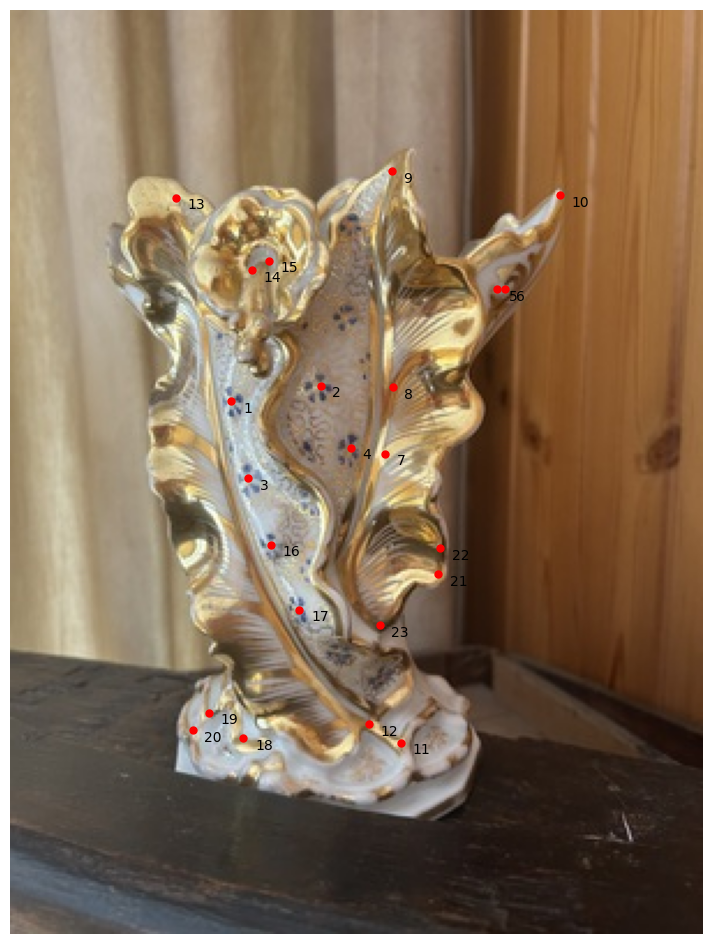

In [7]:
plt.figure(figsize=(16, 12))
plt.imshow(cv2.cvtColor(cv2.imread(img_dir+"view1.jpg"), cv2.COLOR_BGR2RGB))
plt.axis("off")
for i, (x, y) in enumerate(img1_coords):
    plt.plot(x, y, 'ro', markersize=5)  # Plot red circle
    plt.text(x + 5, y + 5, str(i + 1), color="black", fontsize=10)

plt.show()

In [229]:
class Image_Rectifier():
    def __init__(self, points1, points2, img1_path, img2_path, img1=None, img2=None):
        self.F = None
        self.points1 = np.array([point.hc for point in points1])
        self.points2 = np.array([point.hc for point in points2])
        if img1_path != None:
            self.img1 = open_image_in_grayscale(img1_path)
            self.img2 = open_image_in_grayscale(img2_path)
        else:
            self.img1 = img1
            self.img2 = img2
        
    def calculate_fundamental_matrix(self):
        points_mat = []
        for (point1, point2) in zip(self.points1, self.points2):
            x, y, _ = point1 # x (left image)
            xp, yp, _ = point2 # x' (right image)
            
            point_mat_entry = np.array([x*xp, xp*y, xp, x*yp, y*yp, yp, x, y, 1])
            points_mat.append(point_mat_entry)
            
        points_mat = np.vstack(points_mat)
        
        # Estimate fundamental matrix as the Null space
        _, _, Vt = np.linalg.svd(points_mat)
        f = Vt[-1]
        
        F = f.reshape((3,3))
        F = F / F[-1, -1]
        
        # Ensure rank 2:
        U, D, Vt = np.linalg.svd(F)
        D_rank2 = np.array([[D[0], 0, 0],
                            [0, D[1], 0],
                            [0, 0, 0]])
        self.F = U @ D_rank2 @ Vt
        self.F = self.F / self.F[-1, -1]
        
    @staticmethod
    def get_cross_form(ep_vec):
        ep1, ep2, ep3 = ep_vec
        ep_cross = np.array([[0, -ep3, ep2],
                             [ep3, 0, -ep1],
                             [-ep2, ep1, 0]])
        return ep_cross
    
    def get_cononical_form(self):
        # Left projection matrix in canonical form:
        self.P = np.array([[1, 0, 0, 0],
                           [0, 1, 0, 0],
                           [0, 0, 1, 0]])
        self.e = np.array([0, 0, 0]) # Unsure if this needs to be in 3D coords or HC
        # Now to calculate the right epipole and right projection matrix
        # For ep, we know that: F^T ep = 0, so we can get the Null vector to solve this:
        _, _, Vt = np.linalg.svd(self.F.T)
        self.ep = Vt[-1]
        # Normalize e':
        self.ep = self.ep / self.ep[-1]
        
        # Make it into cross product form:
        ep_cross = Image_Rectifier.get_cross_form(self.ep)
        
        self.Pp = np.hstack((ep_cross @ self.F, self.ep.reshape(-1, 1)))
        self.Pp = self.Pp / self.Pp[-1, -1]
    
    @staticmethod
    def cost_func(learnable_params, x_points, xp_points, triangulation=False):
        # Unpack the learnable parameters:
        P = np.array([[1, 0, 0, 0],
                      [0, 1, 0, 0],
                      [0, 0, 1, 0]])
        Pp = learnable_params[:12].reshape((3,4))
        
        # Every three points past is a 3 element vector for the world points;
        world_points = np.array(learnable_params[12:]).reshape(-1, 3)
        # Add w parameter back into world_points:
        world_points = np.hstack((world_points, np.ones((world_points.shape[0], 1))))
        
        # Backproject the world points in image hc coordinates
        x_hat_h = (P @ world_points.T).T
        xp_hat_h = (Pp @ world_points.T).T
        
        # Get the normalized homogenous coordinates
        x_hat = x_hat_h / (x_hat_h[:, 2, np.newaxis] + 1e-8)
        xp_hat = xp_hat_h / (xp_hat_h[:, 2, np.newaxis] + 1e-8)
        
        # Only compare real pixel coordinates, not homogenous coords since we want it to be invariant to a scalar factor of k
        diff_x  = x_points[:, :2]  - x_hat[:, :2]
        diff_xp = xp_points[:, :2] - xp_hat[:, :2]
        
        residuals = np.hstack((diff_x[:, 0], diff_x[:, 1], diff_xp[:, 0], diff_xp[:, 1])).flatten()
        return residuals
    
    @staticmethod
    # As we refine pp, we need to re-estimate the world coordinates:
    def estimate_world_coordinates(P, Pp, points1_hc, points2_hc):
        # Create the matrix to find the world points. A_mat @ X = 0:
        world_points = []
        for i, (point1, point2) in enumerate(zip(points1_hc, points2_hc)):
            x1, y1, _ = point1
            xp, yp, _ = point2
            
            P1, P2, P3 = P[0, :], P[1, :], P[2, :]
            Pp1, Pp2, Pp3 = Pp[0, :], Pp[1, :], Pp[2, :]
            
            A_mat = np.array([x1*P3  - P1,
                              y1*P3  - P2,
                              xp*Pp3 - Pp1,
                              yp*Pp3 - Pp2])
            _, _, Vt = np.linalg.svd(A_mat)
            
            # Get the homogenous coordinates:
            # Each point is 1 column, each point has 4 coords: x, y, z, w
            X_h = Vt[-1]
            
            # Convert to inhomoegenous world points:
            # Each point is 1 column, each point has 4 coords: x, y, z, 1
            X = X_h[:-1] / X_h[-1]
            world_points.append(X)
        world_points = np.array(world_points)
        return world_points
    
    def refine_proj_prime_matrix_with_nonlinear_leastsquares(self):
        learnable_params = self.Pp.flatten()
        idx = np.random.choice(self.points1.shape[0], size=75, replace=False)
        points1 = self.points1[idx]
        points2 = self.points2[idx]
        print(points1.shape, points2.shape)
        world_points = Image_Rectifier.estimate_world_coordinates(self.P, self.Pp, points1, points2)
        learnable_params = np.hstack((learnable_params, world_points.flatten()))
        
        # Apply non-linear least squares optimization to the P' matrix:
        optim_l = least_squares(Image_Rectifier.cost_func, learnable_params, args=(points1,points2, False), method='lm', verbose=2)
        
        learnable_params = optim_l.x
        self.Pp = learnable_params[:12].reshape((3,4))
        self.Pp = self.Pp / self.Pp[-1, -1]
        
        # # Every three points past is a 3 element vector for the world points;
        world_points = np.array(learnable_params[12:]).reshape(-1, 3)
        # Add w parameter back into world_points:
        self.world_points = np.hstack((world_points, np.ones((world_points.shape[0], 1))))
        
    def get_refined_fund_matrix_from_Pp(self):
        # The epipole of P' is its 4th column
        self.ep = self.Pp[:, -1]
        # Normalize e':
        self.ep = self.ep / self.ep[-1]
        
        # We can then calculate a refined value for F:
        ep_cross = Image_Rectifier.get_cross_form(self.ep)
        
        # Refined version of F: F = [e']x P' P+ (P+ = pseudo-inv of P)
        self.F = ep_cross @ self.Pp @ np.linalg.pinv(self.P)
        self.F = self.F / self.F[-1, -1]
        
    def get_homographies_from_refined_F(self):
        h, w = self.img1.shape
        
        # Extract the columns of e' to calculate the angle between the components of e'
        ep1, ep2, _ = self.ep
        
        # Calculate the rotation matrix for the right camera:
        theta = np.arctan2(-(ep2 - h/2), -(ep1 - w/2))
        self.R = np.array([[np.cos(theta), -np.sin(theta), 0],
                          [np.sin(theta), np.cos(theta), 0],
                          [0, 0, 1]])
        
        # After applying the rotation matrix, the epipole should align with the x_axis
        # Ideally, we would get: [f, 0, 1] so: f = er1 / er3 (normalize by third coord) and er2=0 ideally
        ep_rot = self.R @ self.ep
        print(ep_rot)
        focal_len =ep_rot[0] / ep_rot[2]
        
        # RIGHT HOMOGRAPHY #################################################
        # We can now calculate the right homography: H' = G R T
        # Calculate G: the geometric transformation based on the focal length
        G = np.array([[1, 0, 0],
                      [0, 1, 0],
                      [-1/focal_len, 0, 1]])
        h, w = self.img1.shape
        # Calculate T: the translation matrix to shift the center of the image
        T = np.array([[1, 0, -w/2],
                      [0, 1, -h/2],
                      [0, 0, 1]])
        T2 = np.array([[1, 0, w/2],
                      [0, 1, h/2],
                      [0, 0, 1]])
        self.Hp = T2 @ G @ self.R @ T
        self.Hp = self.Hp / self.Hp[-1, -1]
        
        # LEFT HOMOGRAPHY  #################################################
        M = self.Pp @ np.linalg.pinv(self.P)
        M = M / M[-1, -1]
        H_0 = self.Hp @ M
        H_0 = H_0 / H_0[-1, -1]
        
        # We then compute z_i, z_i'
        z, zp = [], []
        for x, xp in zip(self.points1, self.points2):
            z.append(H_0 @ x)
            zp.append(self.Hp @ xp)
        z = np.array(z)
        zp = np.array(zp)
        # Normalize z, zp coordinates:
        z = z / z[:, -1][:, np.newaxis]
        zp = zp / zp[:, -1][:, np.newaxis]
        
        # Using these values, we can build a linear system to solve for the left homography:
        # A * x = b
        x = np.linalg.pinv(z) @ zp[:, 0]
        a, b, c = x
        
        H_A = np.array([[a, b, c],
                        [0, 1, 0],
                        [0, 0, 1]])
        # Calculate the value of H and normalize it by its last value
        self.H = H_A @ H_0
        self.H = self.H / self.H[-1, -1]
        

### Initial estimation of the fundamental matrix, P and P' in canonical form

In [9]:
# ################################################################################################
# ############################ 3.1: Image Rectification ##########################################
img_rectifier = Image_Rectifier(img1_points, img2_points, img_dir+"view1.jpg", img_dir+"view2.jpg")
# Get the Fundamentaal Matrix
img_rectifier.calculate_fundamental_matrix()
print(img_rectifier.F)

[[ 1.76690704e-05 -2.00626641e-06 -1.88485262e-02]
 [ 3.18839844e-05  1.71449073e-06 -3.24668943e-02]
 [ 7.16113840e-03  2.90092554e-02  1.00000000e+00]]


In [10]:
# You can check if your fundamental is correct by checking x'Fx = 0?
x = img_rectifier.points1
xp = img_rectifier.points2
F = img_rectifier.F

errors = []
for x_point, xp_point in zip(x, xp):
    errors.append(np.abs(xp_point @ F @ x_point))
print("Average error: ", np.mean(errors))

Average error:  0.08673900713826616


### Perform non-linear least squares to refine P':

In [11]:
# Calculate the canonical form of the matrix:
img_rectifier.get_cononical_form()

img_rectifier.refine_proj_prime_matrix_with_nonlinear_leastsquares()
img_rectifier.get_refined_fund_matrix_from_Pp()


`ftol` termination condition is satisfied.
Function evaluations 1405, initial cost 1.6670e+02, final cost 3.3692e+00, first-order optimality 2.02e-02.


In [12]:
# You can check if your fundamental is correct by checking x'Fx = 0?
x = img_rectifier.points1
xp = img_rectifier.points2
F = img_rectifier.F

errors = []
for x_point, xp_point in zip(x, xp):
    errors.append(np.abs(xp_point @ F @ x_point))
    
print("Average error: ", np.mean(errors))

Average error:  0.07532237022021596


In [13]:
# After finishing LM estimation of F:
img_rectifier.get_homographies_from_refined_F()
H, Hp = img_rectifier.H, img_rectifier.Hp

[-128.37144421  353.68944927    1.        ]


In [14]:
H_translation = np.array([[1, 0, 150],
                          [0, 1, 150],
                          [0, 0, 1]])
# H_translation = np.array([[1, 0, 0],
#                           [0, 1, 0],
#                           [0, 0, 1]])

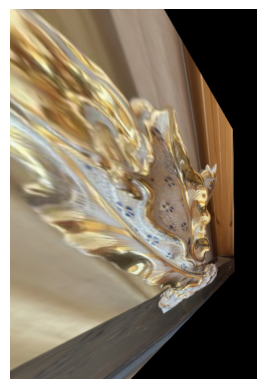

In [15]:
img1 = cv2.imread(img_dir+"view1.jpg")
img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
warped_img1 = cv2.warpPerspective(img1, H_translation@H, (400, 600))
plt.imshow(warped_img1)
plt.axis("off")
plt.show()

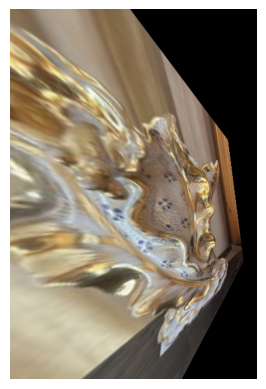

In [16]:
img2 = cv2.imread(img_dir+"view2.jpg")
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
warped_img2 = cv2.warpPerspective(img2, H_translation@Hp, (400, 600))
plt.imshow(warped_img2)
plt.axis("off")
plt.show()

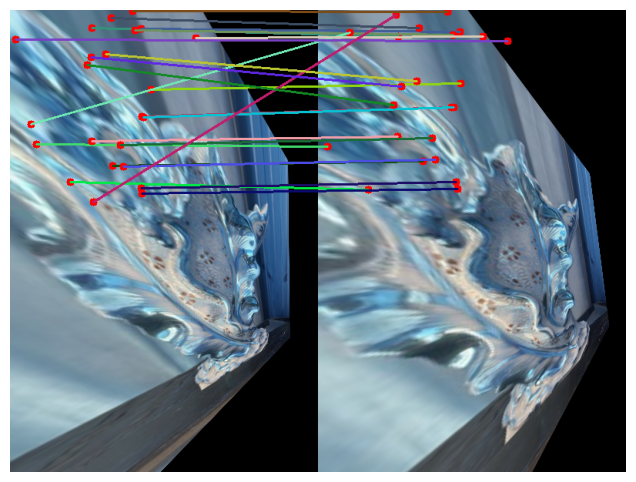

In [17]:
# Print Point Correspondences on rectified images:
# h, w, _ = warped_img1.shape
img1_pointshc = [H @ point.hc for point in img1_points]
img2_pointshc = [Hp @ point.hc for point in img2_points]

# Get the combined warped image:
combined_image = np.hstack((warped_img1, warped_img2))

for i, (point1, point2) in enumerate(zip(img1_pointshc, img2_pointshc)):
    if i>-1: #i != 12 and i != 15 and i != 16 and i != 22:
        x1, y1 = (point1[:2] / point1[2]).astype(np.uint8)
        x2, y2 = (point2[:2] / point2[2]).astype(np.uint8)
        # x1, y1 = x1+150, y1+150
        # y2+= 150
        # x2 += 150
        x2 = x2 + warped_img1.shape[1]
        
        cv2.circle(combined_image, (x1, y1), radius=5, color=(0, 0, 255), thickness=-1)
        cv2.circle(combined_image, (x2, y2), radius=5, color=(0, 0, 255), thickness=-1)
        
        line_color = (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255))
        cv2.line(combined_image, (x1, y1), (x2, y2), color=line_color, thickness=2)
    
combined_image = cv2.cvtColor(combined_image, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(10, 6))
plt.imshow(combined_image)
plt.axis("off")
plt.show()

### 3.2 Interest Point Detection

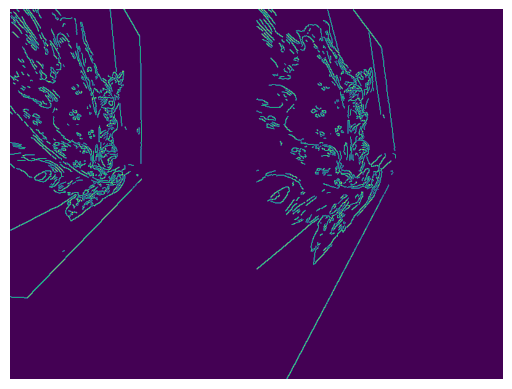

In [155]:
#################################################################################################
# ############################### 3.2: Interest Point Detection ###################################
# Open the images:
img1_bw = np.expand_dims(open_image_in_grayscale(img_dir+"view1.jpg"), axis=-1)
img2_bw = np.expand_dims(open_image_in_grayscale(img_dir+"view2.jpg"), axis=-1)
warped_img1_bw = cv2.warpPerspective(img1_bw, H, (400, 600))
warped_img2_bw = cv2.warpPerspective(img2_bw, Hp, (400, 600))

# Run canny operator for corner detection on the image
edges = cv2.Canny(image=warped_img1_bw, threshold1=150, threshold2=200, apertureSize=3)
edges2 = cv2.Canny(image=warped_img2_bw, threshold1=150, threshold2=200, apertureSize=3)
combined_image = np.hstack((edges, edges2))
plt.imshow(combined_image)
plt.axis("off")
plt.show()

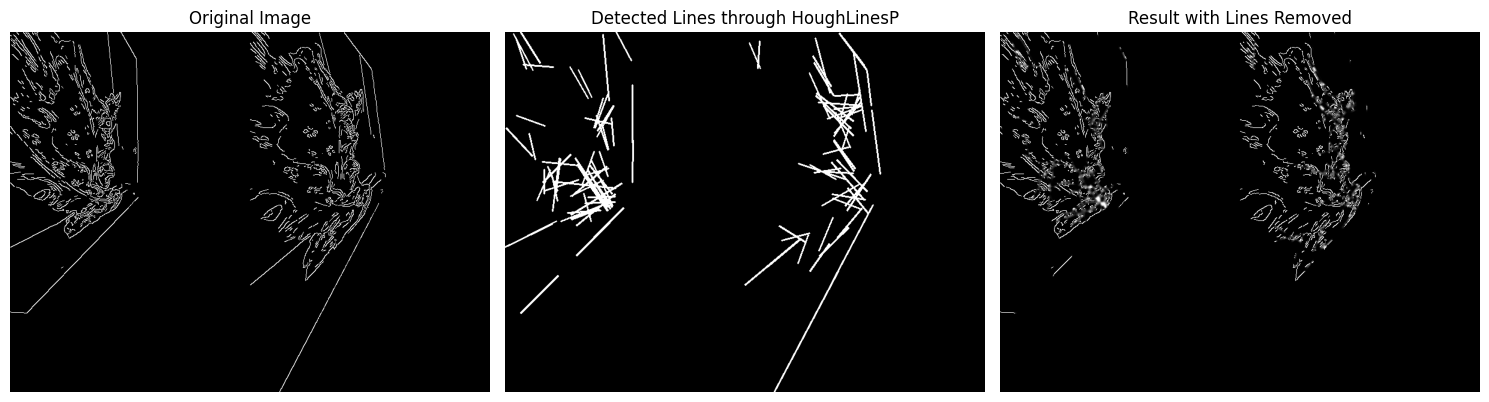

In [156]:
combined_image = np.hstack((edges, edges2))
# Use Hough Line Transform to detect straight lines
lines = cv2.HoughLinesP(combined_image, 1, np.pi/180, threshold=5, minLineLength=40, maxLineGap=10)

# Create a mask to draw the detected lines
line_mask = np.zeros_like(combined_image)

# Draw the detected lines on the mask
if lines is not None:
    for line in lines:
        x1, y1, x2, y2 = line[0]
        cv2.line(line_mask, (x1, y1), (x2, y2), 255, thickness=2)

# Inpaint the image to remove the lines
img_wlines_removed = cv2.inpaint(combined_image, line_mask, inpaintRadius=3, flags=cv2.INPAINT_TELEA)

# Show the original, mask, and result images
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.title("Original Image")
plt.imshow(combined_image, cmap="gray")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.title("Detected Lines through HoughLinesP")
plt.imshow(line_mask, cmap="gray")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.title("Result with Lines Removed")
plt.imshow(img_wlines_removed, cmap="gray")
plt.axis("off")

plt.tight_layout()
plt.show()

In [157]:
edge_to_remove = edges.copy()
# Use Hough Line Transform to detect straight lines
lines = cv2.HoughLinesP(edge_to_remove, 1, np.pi/180, threshold=5, minLineLength=40, maxLineGap=10)

# Create a mask to draw the detected lines
line_mask = np.zeros_like(edge_to_remove)

# Draw the detected lines on the mask
if lines is not None:
    for line in lines:
        x1, y1, x2, y2 = line[0]
        cv2.line(line_mask, (x1, y1), (x2, y2), 255, thickness=2)

# Inpaint the image to remove the lines
left_edge = cv2.inpaint(edge_to_remove, line_mask, inpaintRadius=3, flags=cv2.INPAINT_TELEA)


In [158]:
edge_to_remove = edges2.copy()
# Use Hough Line Transform to detect straight lines
lines = cv2.HoughLinesP(edge_to_remove, 1, np.pi/180, threshold=5, minLineLength=40, maxLineGap=10)

# Create a mask to draw the detected lines
line_mask = np.zeros_like(edge_to_remove)

# Draw the detected lines on the mask
if lines is not None:
    for line in lines:
        x1, y1, x2, y2 = line[0]
        cv2.line(line_mask, (x1, y1), (x2, y2), 255, thickness=2)

# Inpaint the image to remove the lines
right_edge = cv2.inpaint(edge_to_remove, line_mask, inpaintRadius=3, flags=cv2.INPAINT_TELEA)

In [159]:
# Extract edge points from the canny edge map:
kp1 = np.column_stack(np.where(left_edge > 254))
kp2 = np.column_stack(np.where(right_edge > 254))

In [160]:
# I now need to run NCC on the points in the canny edge detector:
# The follwoing code is from my solution for hw4:
def get_masked_corners(corners, area_bound, img):
    return corners[(corners[:, 0] >= area_bound) & (corners[:, 0] <= img.shape[0] - area_bound) &
                                (corners[:, 1] >= area_bound) & (corners[:, 1] <= img.shape[1] - area_bound)]

def SSD(m, img1, corners1, img2, corners2, num_matches):
    area_bound = m+1
    # Remove boundary points that are outside of the neighborhood search area
    # Make sure to check for the boundaries on all sides of the images
    # Corners is a list of points: [(x1,y1), (x2,y2), (x3,y3), ...]
    masked_corners1 = get_masked_corners(corners1, area_bound, img1)
    masked_corners2 = get_masked_corners(corners2, area_bound, img2)
    
    matching_points = []
    for coord1 in masked_corners1:
        # Points are (y,x)
        # Get (m+1) by (m+1) area in the BW image around that corner point
        neighborhood1 = img1[coord1[0]-(area_bound):coord1[0]+(area_bound), coord1[1]-(area_bound):coord1[1]+(area_bound)]
        for coord2 in masked_corners2:
            # Points are meant to be on a horizontal line
            if np.abs(coord2[0] - coord1[0]) < 4 and np.abs(coord2[1] - coord1[1] < 10):
                neighborhood2 = img2[coord2[0]-(area_bound):coord2[0]+(area_bound), coord2[1]-(area_bound):coord2[1]+(area_bound)]
                
                # Calculate the sum of squared distances and add the result to a list to later get the topk
                ssd = np.sum((neighborhood1 - neighborhood2)**2)
                matching_points.append([ssd, [coord1, coord2]])
            
    # Get the top num_matches corner matches (with the highest SSD values first)# Convert to array for easier manipulation
    matching_points = np.array(matching_points, dtype=object)
    print("Number of matches found: ", matching_points.shape)
    
    if num_matches > len(matching_points):
        num_matches = len(matching_points)
    # Sort matching points by SSD (smallest first)
    sorted_matches = sorted(matching_points, key=lambda x: x[0])
    # To store the top correspondences without repeats
    topk_matches = []
    used_coords1 = set()
    used_coords2 = set()
    
    # Iterate over sorted matches and select the top num_matches with unique points
    for match in sorted_matches:
        coord1, coord2 = match[1]
        # Ensure no coordinate from coord1 or coord2 is repeated
        if tuple(coord1) not in used_coords1 and tuple(coord2) not in used_coords2:
            topk_matches.append([coord1, coord2])
            used_coords1.add(tuple(coord1))
            used_coords2.add(tuple(coord2))
        
        # # Stop when we have enough matches
        if len(topk_matches) == num_matches:
            break
    return topk_matches

In [161]:
kp_matches = SSD(20, warped_img1, kp1, warped_img2, kp2, num_matches=1000)

Number of matches found:  (163978, 2)


In [162]:
kp_matches = np.array(kp_matches)

In [163]:
with open("/mnt/cloudNAS3/Adubois/Classes/ECE661/HW9/kp_matches_no_translate.pkl", "wb") as file:
    pickle.dump(kp_matches, file)

In [178]:
with open("/mnt/cloudNAS3/Adubois/Classes/ECE661/HW9/kp_matches_no_translate.pkl", "rb") as file:
    kp_matches = pickle.load(file)

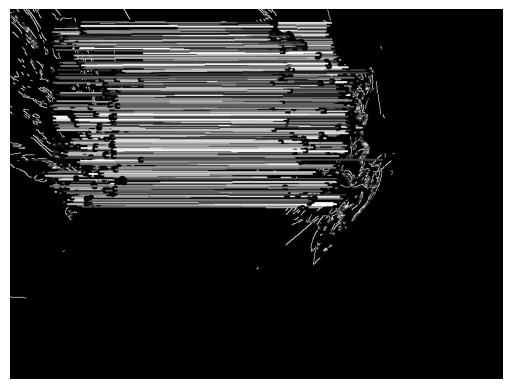

In [179]:
combined_edges = np.hstack((left_edge, right_edge))
for kp_match in kp_matches:
    y1, x1 = kp_match[0]
    y2, x2 = kp_match[1]
    x2 += right_edge.shape[1]
    cv2.circle(combined_edges, (x1, y1), radius=5, color=(0, 0, 255), thickness=-1)
    cv2.circle(combined_edges, (x2, y2), radius=5, color=(0, 0, 255), thickness=-1)
    
    line_color = (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255))
    cv2.line(combined_edges, (x1, y1), (x2, y2), color=line_color, thickness=2)
plt.imshow(combined_edges, cmap="gray")
plt.axis("off")
plt.show()

### 3D Reconstruction:

In [190]:
# Recreate the points from the rectified images onto the original image
# I also remove border points again which helps to remove the final errors. I do this by applying a mask around the border of the image

img_1 = cv2.imread(img_dir+"view1.jpg")
img_2 = cv2.imread(img_dir+"view2.jpg")

og_points1, og_points2 = [], []
for points in kp_matches:
    y1, x1 = points[0]
    y2, x2 = points[1]
    
    hc1 = np.array([x1, y1, 1])
    hc2 = np.array([x2, y2, 1])
    
    og_coord1 = np.linalg.inv(H) @ hc1
    og_coord2 = np.linalg.inv(Hp) @ hc2
    
    og_point1 = Point.from_hc(og_coord1)
    og_point2 = Point.from_hc(og_coord2)
    
    x1, y1, _ = og_point1.hc
    x2, y2, _ = og_point2.hc
    
    if (y1 < img_1.shape[0] - 30 and x1 < img_1.shape[1] - 30) and (y2 < img_2.shape[0] - 30 and x2 < img_2.shape[1] - 30):
        og_points1.append(og_point1)
        og_points2.append(og_point2)
        
# Remove the homography on the points so that they apply to the original images:
# kp1_points = [Point.from_hc(Point(x, y).apply_homography(np.linalg.inv(H))) for (x, y) in kp1_coords]
# kp2_points = [Point.from_hc(Point(x, y).apply_homography(np.linalg.inv(Hp))) for (x, y) in kp2_coords]


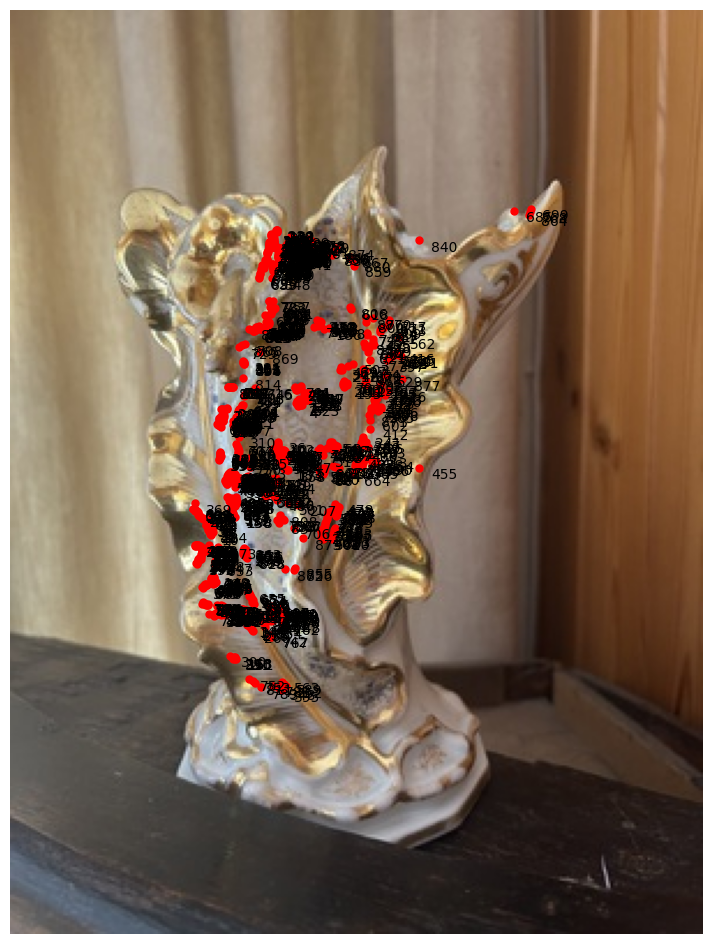

In [199]:
plt.figure(figsize=(16, 12))
img_2 = cv2.cvtColor(cv2.imread(img_dir+"view2.jpg"), cv2.COLOR_BGR2RGB)
plt.imshow(img_2)
plt.axis("off")
for i, points in enumerate(og_points2):
    x, y, _ = points.hc
    plt.plot(x, y, 'ro', markersize=5)  # Plot red circle
    plt.text(x + 5, y + 5, str(i + 1), color="black", fontsize=10)

plt.show()

In [230]:
# Repeat steps 1-4:
img_rectifier_final = Image_Rectifier(og_points1, og_points2, img_dir+"view1.jpg", img_dir+"view2.jpg")#, warped_img1, warped_img2)
# Get the Fundamentaal Matrix
img_rectifier_final.calculate_fundamental_matrix()
print(img_rectifier_final.F)

[[ 2.75270544e-05  1.21427432e-05 -6.89002957e-03]
 [ 4.86668471e-06  2.85288231e-06 -1.22878868e-03]
 [-3.97810205e-03 -2.03841528e-03  1.00000000e+00]]


In [231]:
# Calculate the canonical form of the matrix:
img_rectifier_final.get_cononical_form()

img_rectifier_final.refine_proj_prime_matrix_with_nonlinear_leastsquares()
img_rectifier_final.get_refined_fund_matrix_from_Pp()

(75, 3) (75, 3)


`ftol` termination condition is satisfied.
Function evaluations 179579, initial cost 3.0267e+06, final cost 2.9931e+01, first-order optimality 2.16e-02.


In [232]:
# You can check if your fundamental is correct by checking x'Fx = 0?
x = img_rectifier_final.points1
xp = img_rectifier_final.points2
F = img_rectifier_final.F

errors = []
for x_point, xp_point in zip(x, xp):
    errors.append(np.abs(xp_point @ F @ x_point))
    
print("Average error: ", np.mean(errors))

Average error:  0.08945704042073173


In [233]:
# Reconstruct the points:
P = img_rectifier_final.P
Pp = img_rectifier_final.Pp
x = [point.hc for point in og_points1]
xp = [point.hc for point in og_points2]
world_points = Image_Rectifier.estimate_world_coordinates(P, Pp, x, xp)

In [251]:
with open("./world_points.pkl", "wb") as file:
    pickle.dump(world_points, file)

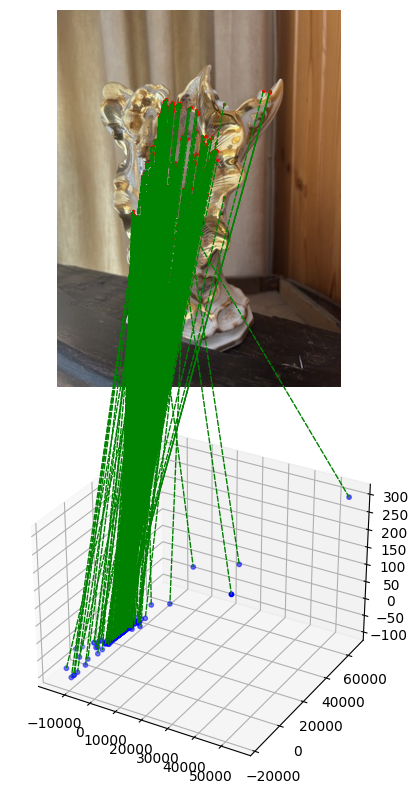

<Figure size 640x480 with 0 Axes>

In [254]:
from matplotlib.patches import ConnectionPatch
from mpl_toolkits.mplot3d import proj3d

# Create a figure
fig = plt.figure(figsize=(10, 8))

img_points = np.array([point.hc[:2] for point in og_points2])

# Plot 2D image with points
ax1 = fig.add_subplot(2, 1, 1)  # Top subplot
ax1.imshow(img_2)
ax1.scatter(img_points[:, 0], img_points[:, 1], c='red', s=2, label='2D Points')  # Note x, y swap
ax1.axis("off")


# Plot 3D points
ax2 = fig.add_subplot(2, 1, 2, projection='3d')  # Bottom subplot

# Plot 3D points in the world frame
ax2.scatter(
    world_points[:, 0],
    world_points[:, 1],
    world_points[:, 2],
    c='b', s=10, label='3D points (world frame)'
)

# Draw lines connecting points from 2D to 3D across subplots
# This part of the code was based on a Piazza post question 91 on how to plot lines between both figure axes.
for i in range(len(img_points)):
    # Get 2D point coordinates
    x2d, y2d = img_points[i, 0], img_points[i, 1]

    # Get 3D point in screen coordinates
    x3d, y3d, _ = proj3d.proj_transform(world_points[i, 0], world_points[i, 1], world_points[i, 2], ax2.get_proj())

    # Create a ConnectionPatch from the 2D point to the 3D screen coordinates
    con = ConnectionPatch(
        xyA=(x2d, y2d),
        coordsA=ax1.transData,
        xyB=(x3d, y3d),
        coordsB=ax2.transData,
        color="green", linestyle="--", linewidth=1
    )
    fig.add_artist(con)

plt.tight_layout()
plt.show()